In [1]:
import os
from classification_models.tfkeras import Classifiers

ResNet34, preprocess_input = Classifiers.get('resnet34')

In [2]:
log_dir = "logs/"
os.makedirs(log_dir, exist_ok=True)

%reload_ext tensorboard
%tensorboard --logdir {log_dir} --reload_multifile True --host 0.0.0.0 --port 6006

In [3]:
# Run only for training!
import glob
import math
import datetime
import numpy as np
import tensorflow as tf

# Change parameters here...
data_dir = '../data/' # Change
sizex = 500
sizey = 500
sizez = 3
batch_size = 32
nb_epochs = 50
validation_ratio = 0.3

In [4]:
# Collect all the .npz files
numpy_datasets = glob.glob(data_dir+'dataset*')

In [5]:
# METHOD 1: (first 4 files)
# load the data into numpy arrays from npz files:
for dataset in numpy_datasets[:4]:
    try:
        with np.load(dataset) as data:
            x_dust   = np.append( x_dust, data['x_dust'],axis=0)
            x_nodust = np.append( x_nodust, data['x_nodust'],axis=0)
            y        = np.append( y, data['y'],axis=0)
            ids      = np.append( ids, data['id'],axis=0)
    except:
        with np.load(dataset) as data:
            x_dust   = data['x_dust']
            x_nodust = data['x_nodust']
            y        = data['y']
            ids      = data['id']

In [6]:
# METHOD 2: (first 4 files)
# load the data into a dictionary from npz files
data_dict = {}
for dataset in numpy_datasets[:4]:
    with np.load(dataset) as data:
        if 'x_dust' in data_dict.keys():
            data_dict['x_dust']   = np.append( data_dict['x_dust'], data['x_dust'],axis=0)
            data_dict['x_nodust'] = np.append( data_dict['x_nodust'], data['x_nodust'],axis=0)
            data_dict['y']        = np.append( data_dict['y'], data['y'],axis=0)
            data_dict['ids']      = np.append( data_dict['ids'], data['id'],axis=0)
        else:
            data_dict['x_dust']   = data['x_dust']
            data_dict['x_nodust'] = data['x_nodust']
            data_dict['y']        = data['y']
            data_dict['ids']      = data['id']

In [7]:
# check the sahpe of the array (100 images of 500x500x3 = 4 files of 25 images)
x_dust.shape

(100, 500, 500, 3)

In [8]:
# check the shape of the dictionary (100 images of 500x500x3 = 4 files of 25 images)
data_dict['x_dust'].shape

(100, 500, 500, 3)

In [9]:
# Normalice the angular momentum
from sklearn.preprocessing import normalize
data_dict['y_norm'] = normalize(data_dict['y'], axis=1)

# Compute the angles from the x,y,z labels
# theta = np.arctan(np.sqrt(x**2 + y**2)/z)
# phi = np.arctan(y/x)
def cart_to_esf(xyz):
    angles = np.empty( (len(xyz),2) )
    angles[:,0] = np.arctan2(np.sqrt(xyz[:,0]**2 + xyz[:,1]**2),xyz[:,2]) *180/np.pi #theta angle in degrees
    angles[:,1] = np.arctan2(xyz[:,1],xyz[:,0]) * 180/np.pi #phi angle in degrees
    return angles

def esf_to_cart(angles):
    xyz = np.empty( (len(angles),3) )
    ang_rad = angles*np.pi/180
    xyz[:,0] = np.sin(ang_rad[:,0])*np.cos(ang_rad[:,1])
    xyz[:,1] = np.sin(ang_rad[:,0])*np.sin(ang_rad[:,1])
    xyz[:,2] = np.cos(ang_rad[:,0])
    return xyz

data_dict['y_angle'] = cart_to_esf(data_dict['y_norm'])
data_dict['y_xyz']   = esf_to_cart(data_dict['y_angle'])

In [10]:
data_dict['y_norm'].shape
data_dict['y_angle'].shape

(100, 2)

In [11]:
# create the dataset from the dictionary and see the size and type
dataset = tf.data.Dataset.from_tensor_slices(data_dict)
print(dataset)

<TensorSliceDataset shapes: {x_dust: (500, 500, 3), x_nodust: (500, 500, 3), y: (3,), ids: (), y_norm: (3,), y_angle: (2,), y_xyz: (3,)}, types: {x_dust: tf.float64, x_nodust: tf.float64, y: tf.float64, ids: tf.string, y_norm: tf.float64, y_angle: tf.float64, y_xyz: tf.float64}>


In [12]:
# separate in batches and shuffle the data with a fixed seed
#dataset = dataset.batch(batch_size)
#dataset = dataset.shuffle(10, seed=123)
AUTO = tf.data.experimental.AUTOTUNE

<TensorSliceDataset shapes: {x_dust: (500, 500, 3), x_nodust: (500, 500, 3), y: (3,), ids: (), y_norm: (3,), y_angle: (2,), y_xyz: (3,)}, types: {x_dust: tf.float64, x_nodust: tf.float64, y: tf.float64, ids: tf.string, y_norm: tf.float64, y_angle: tf.float64, y_xyz: tf.float64}>


#### **Label:** [-0.86945268  0.45658841 -0.18862412]

#### **angle:** [100.87250023 152.29403106]

#### **inverse:** [-0.86945268  0.45658841 -0.18862412]

tf.Tensor(b'g4.86e10_x302_y97_z327', shape=(), dtype=string)


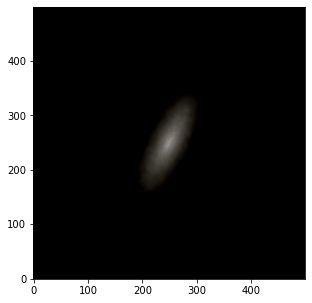

#### **Label:** [-0.78373714 -0.07462434  0.6165933 ]

#### **angle:** [  51.93221596 -174.56092096]

#### **inverse:** [-0.78373714 -0.07462434  0.6165933 ]

tf.Tensor(b'g4.86e10_x63_y282_z262', shape=(), dtype=string)


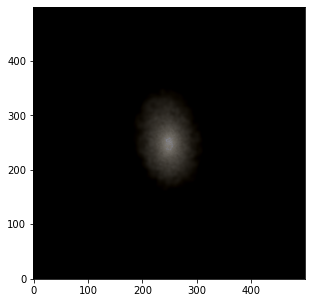

In [13]:
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

def viz(ds):
    elem = ds.take(1)
    for e in elem:
        img = e['x_nodust'][:, :,:]
        fig, ax = plt.subplots(figsize=(5,5))
        im = ax.imshow(img, cmap='gray', vmin=0, vmax=255,origin='lower')
        display(Markdown("#### **Label:** {}".format(e['y_norm'])))
        display(Markdown("#### **angle:** {}".format(e['y_angle'])))
        display(Markdown("#### **inverse:** {}".format(e['y_xyz'])))
        print(e['ids'])
        plt.show()
        break

def viz_batch(ds, idx):
    elem = ds.take(1) # get first batch
    for e in elem:
        img = e['x_nodust'][idx, :, :,:]
        fig, ax = plt.subplots(figsize=(5,5))
        im = ax.imshow(img, cmap='gray', vmin=0, vmax=255, origin='lower')
        display(Markdown("#### **Label:** {}".format(e['y_norm'][idx])))
        display(Markdown("#### **angle:** {}".format(e['y_angle'][idx])))
        display(Markdown("#### **inverse:** {}".format(e['y_xyz'][idx])))
        print(e['ids'][idx])
        plt.show()
        break

print(dataset)
viz(dataset)
real_dataset = dataset.batch(batch_size).shuffle(10, seed=123)
viz_batch(real_dataset, 2) # select any index within the batch, e.g. 2

In [14]:
# Build model
base_model = ResNet34(input_shape=(sizey,sizex,3), weights='imagenet', include_top=False)

# TODO: Only retrain the last X layers (e.g. last 30)
#for l in base_model.layers[:-30]:
#    l.trainable = False
#for layer in base_model.layers:
#    print(layer, layer.trainable)

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])

# Use existing best weights if available...
snapshot_weights = 'best_weights.hdf5'
if os.path.isfile(snapshot_weights):
    model.load_weights(snapshot_weights)


model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

# For tensorboard
log_dir_s = log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir_s, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_s, histogram_freq=1, update_freq='batch', profile_batch=0)

# Checkpointing
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=snapshot_weights,
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True)

callbacks = [
    tensorboard_callback,
    checkpointer
]

model.fit(
    dataset,
    validation_data = dataset,
    epochs = nb_epochs,
    callbacks = callbacks,)
    # class_weight=class_weight)

model.save('trained.h5') # Not really needed as we have the weights already

85524480/85521592 [==============================] - 40s 0us/step
Epoch 1/50


KeyError: in user code:

    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:717 call
        return self._run_internal_graph(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:826 _run_internal_graph
        inputs = self._flatten_to_reference_inputs(inputs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:926 _flatten_to_reference_inputs
        return [tensors[inp._keras_history.layer.name] for inp in ref_inputs]
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:926 <listcomp>
        return [tensors[inp._keras_history.layer.name] for inp in ref_inputs]

    KeyError: 'data'
